# Wordle Solver Virtual Assistant (WSVA) Analysis

## Experiment Design

Select 10 words at random from [previous Wordle games](https://github.com/jimthompson5802/wordle_solver/blob/main/data/f-past-wordle-answers.txt). This list is as of 27Jan2024.  

For each word, attempt to guess the word using the two solver types: `llm`, which uses OpenAI GPT4 LLM, and `random` guessing. For each solver type and each word, run 10 trials and record the number of guesses required to guess the word.

Each trial will interact with a local Wordle simulator.  This simulator will provide the same feedback as the real Wordle game:
* identify correct letters in the correct position
* identify correct letters in the wrong position
* identify incorrect letters

This simulator will allow guesses past the six allowed in the real game, up to a maximum of 20 guess.  If the word is guessed with six or less attemppts, the trial will be considered a success, otherwise it will be considered a failure.

Data for this experiment is generated by `src/run_experiment.py`.  This script will run the experiment and save the results to `data/experiment.csv`.

In [1]:
import pandas as pd

/tmp/ipykernel_1002/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the experiment data from a CSV file
df = pd.read_csv('../data/experiment.csv')

# Add a new column 'solved_wordle' to the dataframe. 
# This column is True if 'num_attempts' is less than or equal to 6 (indicating the Wordle was solved within the allowed attempts), and False otherwise.
df["solved_wordle"] = df.num_attempts <= 6

# Display a random sample of 5 rows from the dataframe
df.sample(5)

,solver_type,initial_word,word,num_attempts,solved_wordle
61,random,adieu,these,5,True
140,llm,crate,manly,6,True
82,random,adieu,whisk,4,True
160,llm,trace,these,3,True
147,llm,adieu,manly,6,True


## Compare Success Rates for the Random and LLM Solvers

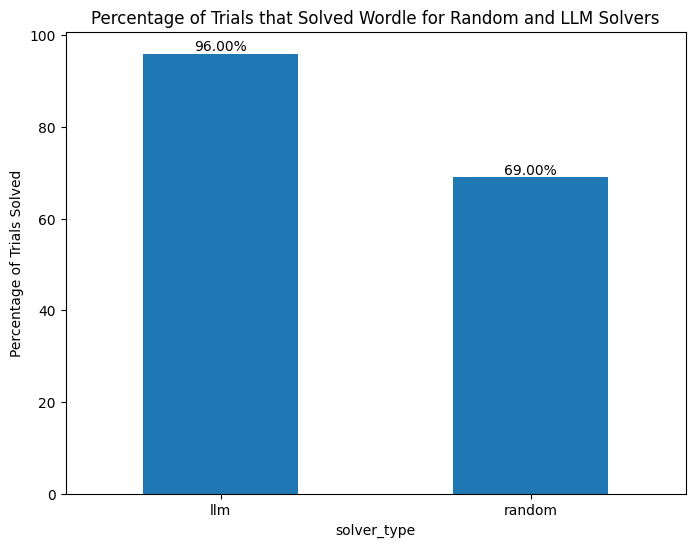

In [3]:
import matplotlib.pyplot as plt

# Group by solver and calculate the percentage of solved Wordle
solved_percentages = df.groupby('solver_type')['solved_wordle'].mean() * 100

# Plot
plt.figure(figsize=(8, 6))
bars = solved_percentages.plot(kind='bar')
plt.ylabel('Percentage of Trials Solved')
plt.title('Percentage of Trials that Solved Wordle for Random and LLM Solvers')

# Add percentage labels on top of each bar
for bar in bars.patches:
    bars.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
              f'{bar.get_height():.2f}%', ha='center', va='bottom')

# Rotate x-axis labels
plt.xticks(rotation=0)
plt.savefig('../docs/images/percentage_solved.png')
plt.show()

In [4]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['solver_type'], df['solved_wordle'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square statistic: {chi2}")
print(f"P-value: {p}")

Chi-Square statistic: 23.41125541125541
P-value: 1.3081092064596102e-06


The results of the Chi-Square test, as indicated by a Chi-Square statistic of 23.41 and an exceptionally low P-value of 1.3081e-06, strongly suggest a significant statistical association between the categorical variables under examination, `solver_type` and `solved_wordle`. The high Chi-Square value points to a substantial divergence between the observed data and the expected frequencies under the null hypothesis, which proposes no relationship between the variables. The P-value, being well below the conventional significance level of 0.05, further reinforces this finding. It indicates that the probability of observing such a marked difference under the assumption of the null hypothesis is extremely low. Consequently, these results lead to the rejection of the null hypothesis, implying that there is a statistically significant relationship between the studied variables, contrary to the assumption of independence posited by the null hypothesis.

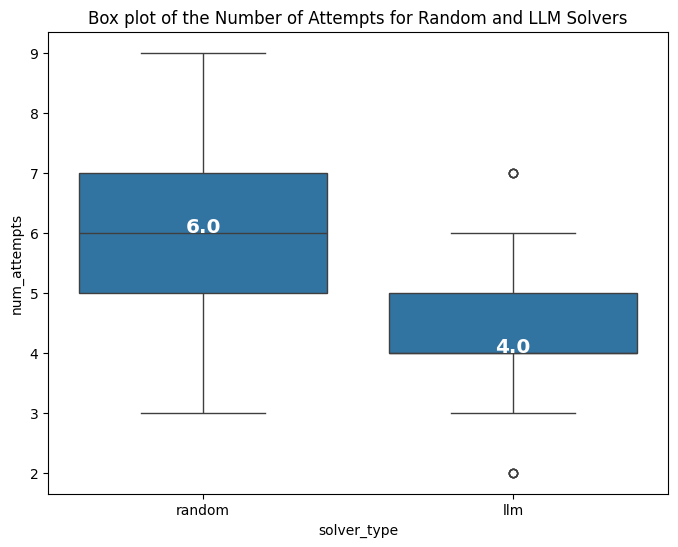

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a box plot
plt.figure(figsize=(8, 6))
box_plot = sns.boxplot(x='solver_type', y='num_attempts', data=df)

medians = df.groupby(['solver_type'])['num_attempts'].median().values
medians = medians[::-1] # reverse order to match the boxplot order
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,box_plot.get_xticklabels()):
    box_plot.text(pos[tick], medians[tick], median_labels[tick], 
            horizontalalignment='center', size='x-large', color='w', weight='semibold')

plt.title('Box plot of the Number of Attempts for Random and LLM Solvers')
plt.savefig('../docs/images/boxplot_num_attempts.png')
plt.show()

In [6]:
df.groupby('solver_type')['num_attempts'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
solver_type,,,,,,,,,,,
llm,100.0,4.36,1.159240,2.0,4.0,4.0,5.0,6.0,6.0,7.0,7.0
random,100.0,5.98,1.340737,3.0,5.0,6.0,7.0,8.0,8.0,9.0,9.0


The boxplot show that the median number of attempts for the random solver is 6, while the median number of attempts for the llm solver is 4. This suggests that the LLM solver is more likely to solve the Wordle within the allowed 6 attempts.

## Detailed Analysis for LLM Solver

### LLM Solver Success Rate by Test Word

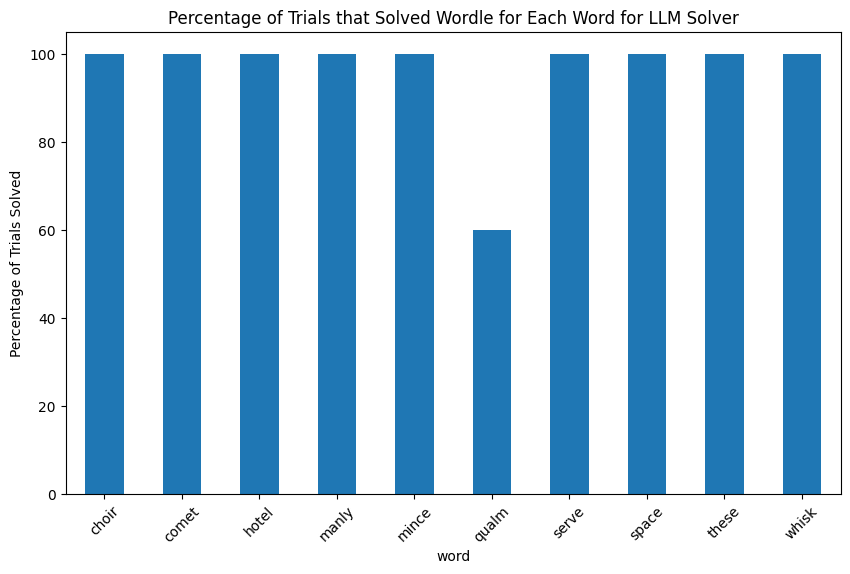

In [7]:
import matplotlib.pyplot as plt

# Filter for 'llm' solver type, group by 'word' and calculate the percentage of solved Wordle
llm_word_solved_percentages = df[df['solver_type'] == 'llm'].groupby('word')['solved_wordle'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
llm_word_solved_percentages.plot(kind='bar')
plt.ylabel('Percentage of Trials Solved')
plt.title('Percentage of Trials that Solved Wordle for Each Word for LLM Solver')
plt.xticks(rotation=45)
plt.show()

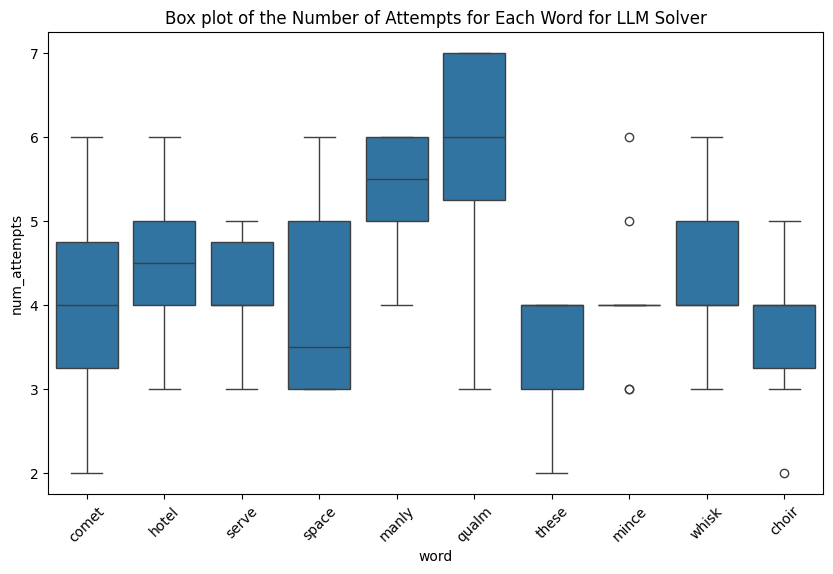

In [8]:
import seaborn as sns

# Filter for 'llm' solver type
llm_df = df[df['solver_type'] == 'llm']

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='word', y='num_attempts', data=llm_df)
plt.title('Box plot of the Number of Attempts for Each Word for LLM Solver')
plt.xticks(rotation=45)
plt.show()

### Initial Word Guess Analysis

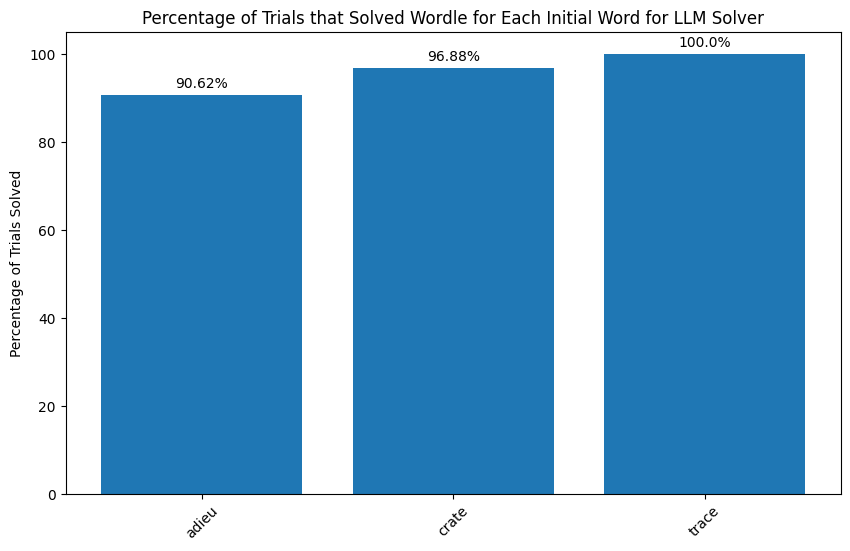

In [9]:
import matplotlib.pyplot as plt

# Filter for 'llm' solver type, group by 'initial_word' and calculate the percentage of solved Wordle
llm_initial_word_solved_percentages = df[df['solver_type'] == 'llm'].groupby('initial_word')['solved_wordle'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(llm_initial_word_solved_percentages.index, llm_initial_word_solved_percentages.values)
plt.ylabel('Percentage of Trials Solved')
plt.title('Percentage of Trials that Solved Wordle for Each Initial Word for LLM Solver')
plt.xticks(rotation=45)

# Add percentage on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{round(yval, 2)}%", ha='center', va='bottom')

plt.savefig('../docs/images/percentage_solved_initial_word.png')
plt.show()

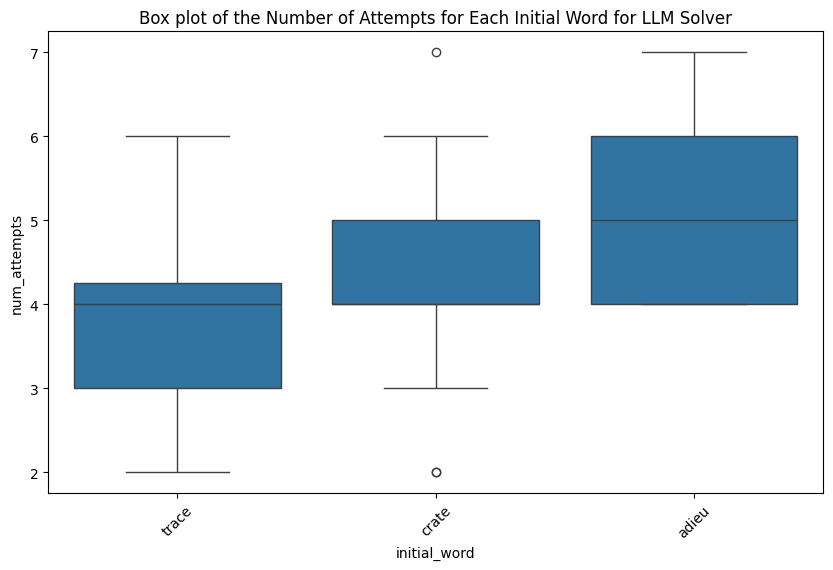

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for 'llm' solver type
llm_df = df[df['solver_type'] == 'llm']

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='initial_word', y='num_attempts', data=llm_df)
plt.title('Box plot of the Number of Attempts for Each Initial Word for LLM Solver')
plt.xticks(rotation=45)

plt.savefig('../docs/images/boxplot_num_attempts_initial_word.png') 
plt.show()

In [11]:
# Group by 'initial_word' and generate descriptive statistics for 'num_attempts'
df[df.solver_type == "llm"].groupby('initial_word')['num_attempts'].describe()

,count,mean,std,min,25%,50%,75%,max
initial_word,,,,,,,,
adieu,32.0,5.093750,0.995453,4.0,4.0,5.0,6.00,7.0
crate,32.0,4.250000,1.107161,2.0,4.0,4.0,5.00,7.0
trace,36.0,3.805556,1.009086,2.0,3.0,4.0,4.25,6.0


This shows that `trace` appears to be the better initial word to use.